# Import libraries

In [1]:
# !pip install ibmcloudant
# !pip install cvxopt
import pandas as pd
import numpy as np
import copy
from cvxopt.base import matrix
from cvxopt.modeling import op, dot, variable, max, min
from cloudant.client import Cloudant
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Preprocessing of data

### Source:
- New Jersey Monkeypox Data: https://dashboards.doh.nj.gov/views/public-MonkeypoxCasesandVaccinations_16642095083250/NJMPXDashboard?:origin=card_share_link&:embed=y&:isGuestRedirectFromVizportal=y
- The data will be fetched and updated on a weekly basis

### Vaccine facilities: 
- Source: https://www.nj.gov/health/monkeypox/vaccines/
- These are the facilities that provide Monkeypox vaccines across the state of New Jersey. Each vaccine provider is listed as a **supply agent *i***. 
- We scrape the official website to obtain the list of vaccine facilities available in New Jersey.

In [2]:
providers = pd.read_csv('providers.csv', index_col = 0)
providers

,Provider,Address,County
0,AtlantiCare FQHC,"1925 Pacific Ave, NJ 08401",Atlantic
1,Bergen New Bridge Medical Center,"230 East Ridgewood Ave., Paramus, NJ 07652",Bergen
2,City of Elizabeth Health Department,"418 Palmer street, Elizabeth, NJ 07202",Union
3,City of Trenton Health Department,"828 North Olden Ave, Trenton, NJ 08638",Mercer
4,"Cooper Vaccine Clinic, Cooper University Hospital","300 Broadway, Camden, NJ 08103",Camden
5,Eric B. Chandler Health Center,"277 George St, New Brunswick, NJ 08901",Middlesex
6,Hamilton Division of Health,"2100 Greenwood Avenue, Hamilton, NJ 08609",Mercer
7,Hyacinth AIDS Foundation/Project Living Out Loud!,"Jersey City, NJ 07304",Hudson
8,Jackson Street Gym,"605 Jackson Ave, Hoboken, NJ 07030",Hudson
9,Neighborhood Health Services,"1700 Myrtle Ave, Plainfield, NJ 07063",Union


### Neighboring counties
- It is obviouse that not every county has a vaccine facility. So how do we ensure that, say, a user from a county that does not have any vaccine provider gets matched with one? In this case, we would look for vaccine facilities in **neighboring counties** to that user's county, and even neighbors of those neighboring counties, until we have at least 5 vaccine facilities for that person.
- Source file for adjacent counties in the US: https://github.com/abhirupdatta/UScounties

In [3]:
data = pd.read_csv("countyadj.csv", index_col = 0)
counties = [county for county in data.index if county[-2:] == 'NJ']
adjacent_counties = data[counties].loc[counties]
intersection = adjacent_counties.index.intersection(adjacent_counties.columns)
for item in intersection:
    adjacent_counties.loc[item, item] = 1
counties = [county[:-10] for county in counties]
adjacent_counties.index = adjacent_counties.columns = counties
adjacent_counties = adjacent_counties.sort_index().sort_index(axis = 1)
adjacent_counties.head()

,Atlantic,Bergen,Burlington,Camden,Cape May,Cumberland,Essex,Gloucester,Hudson,Hunterdon,...,Middlesex,Monmouth,Morris,Ocean,Passaic,Salem,Somerset,Sussex,Union,Warren
Atlantic,1,0,1,1,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
Bergen,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Burlington,1,0,1,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Camden,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Cape May,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create types of users
- For each county, we create 5types of users: American Indian or Alaskan Native, Asian, Black or African American, Hispanic, Multi Race, Native Hawaiian or Other Pacific Islander, Other, White.

In [4]:
races = ['Asian', 'Black', 'White', 'Other', 'Hispanic']
race_num = len(races)
mu_g = np.array([10.3, 15.3, 53.5, 0.7 + 0.1 + 2.4, 21.5])
mu_g = mu_g/sum(mu_g)
users = [(county, race) for county in adjacent_counties.index for race in races]
users

[('Atlantic', 'Asian'),
 ('Atlantic', 'Black'),
 ('Atlantic', 'White'),
 ('Atlantic', 'Other'),
 ('Atlantic', 'Hispanic'),
 ('Bergen', 'Asian'),
 ('Bergen', 'Black'),
 ('Bergen', 'White'),
 ('Bergen', 'Other'),
 ('Bergen', 'Hispanic'),
 ('Burlington', 'Asian'),
 ('Burlington', 'Black'),
 ('Burlington', 'White'),
 ('Burlington', 'Other'),
 ('Burlington', 'Hispanic'),
 ('Camden', 'Asian'),
 ('Camden', 'Black'),
 ('Camden', 'White'),
 ('Camden', 'Other'),
 ('Camden', 'Hispanic'),
 ('Cape May', 'Asian'),
 ('Cape May', 'Black'),
 ('Cape May', 'White'),
 ('Cape May', 'Other'),
 ('Cape May', 'Hispanic'),
 ('Cumberland', 'Asian'),
 ('Cumberland', 'Black'),
 ('Cumberland', 'White'),
 ('Cumberland', 'Other'),
 ('Cumberland', 'Hispanic'),
 ('Essex', 'Asian'),
 ('Essex', 'Black'),
 ('Essex', 'White'),
 ('Essex', 'Other'),
 ('Essex', 'Hispanic'),
 ('Gloucester', 'Asian'),
 ('Gloucester', 'Black'),
 ('Gloucester', 'White'),
 ('Gloucester', 'Other'),
 ('Gloucester', 'Hispanic'),
 ('Hudson', 'Asian'),

### Add edges
- We add an edge between a user and a vaccine provider if they share the same county or adjacent to each other. We continuously look for neighbors of those adjacent counties until we ensure that each user is connected to at least 6 providers.

In [5]:
I_num = len(providers)
J_num = len(users)
min_providers = 7
E = np.zeros((I_num, J_num), dtype = int) # 0 represents no edge

# we look for providers in located in the same and neighbor counties as the users
for j in range(J_num):
    location_user = [users[j][0]]
    while len(np.where(E[:,j] == 1)[0]) < min_providers: # find user and provider that satisfies, else, enlarge the range until no more provider
        tmp = set()
        for loc in location_user:
            neighbors = adjacent_counties.columns[np.where(adjacent_counties[loc] == 1)]
            for neighbor in neighbors:
                tmp.add(neighbor)
                providers_neighbor = np.where(providers['County'] == neighbor)[0]
                for idx in providers_neighbor:
                    E[idx][j] = 1 # 1 represents edge
        location_user = list(tmp) 
        
edges = []
E_list = []
E_num = 0
for i in range(I_num):
    for j in range(J_num):
        if E[i][j] == 1:
            edges.append((providers.iloc[i]['Provider'], users[j]))
            E_list.append((i, j))
            E_num += 1

### Create serving capacity for each provider

- The serving capacity of a provider represents the total number of registration slots it could give to users. We make an estimation of this based on the number of vaccines administered every week. Hence, the capacity will also be updated per week.

- For our experiment, we create synthetic data for the number of slots. Assume we have n slots, then each provider will have `n * number of edges of a provider/total number of edges`.

In [6]:
total_capacity = 10000 # this will be changed weekly
edges_percentage = np.array([len(np.where(E[i,:] == 1)[0]) for i in range(len(E))])
edges_percentage = edges_percentage/edges_percentage.sum()
capacities = np.round(total_capacity * edges_percentage).astype(int)
for i in range(total_capacity - sum(capacities)):
    idx = np.random.choice(len(providers))
    capacities[idx] += 1

### Create arrival rate for each user
- The arrival rate of a user `j` follows a Poisson distribution. This means that when a user arrives, the probability that user is the user `j` is $\lambda_j$. In reality, the demand for resource such as vaccine is always larger than the supply. We denote this as **supply scarcity**, or $\rho$. We expect our system can handle an arriving population that is $\rho$ times larger than the total capacity. 
- For our experiment, we create synthetic data for arrival rate as the vaccination progress of each race.

In [7]:
supply_scar = 1 # manual parameter
vaccination_progress = np.asarray([8, 12, 41, 7, 23] * len(adjacent_counties))
vaccination_progress = vaccination_progress/sum(vaccination_progress)
arrival_rate = vaccination_progress * total_capacity * supply_scar

# Offline model

In [8]:
# coefficients matrix for constraints
E_j = np.zeros((J_num, E_num))
E_g = np.zeros((race_num, E_num))
E_i = np.zeros((I_num, E_num))

# list of edges
idx_e = 0 # edge counter since the order of edges follows in the format i rows * j columns
for i in range(I_num):
    for j in range(J_num):
        if E[i][j] == 1:
            E_j[j][idx_e] = 1
            E_g[j % race_num][idx_e] = 1 / (sum(arrival_rate) * mu_g[j % race_num])            
            E_i[i][idx_e] = 1
            idx_e += 1

# define variables and objective function
x_ij = variable(E_num)
obj = max(-1 * matrix(E_g) * x_ij)

constraints = []
# constraint (2)
constraints.append(matrix(E_j) * x_ij <= matrix(arrival_rate.astype('float')))
# constraint (4)
constraints.append(matrix(E_i) * x_ij <= matrix(capacities.astype('float')))
# constraint (5)
constraints.append(x_ij >= 0)

# solve LP
lp_opt = op(obj, constraints)
lp_opt.solve()
opt_val = -1 * lp_opt.objective.value()[0]
x_ij = np.asarray(x_ij.value)

     pcost       dcost       gap    pres   dres   k/t
 0: -1.3300e+00 -2.0004e+04  2e+04  1e-01  3e+01  1e+00
 1:  1.2079e+00 -2.1942e+03  1e+03  1e-02  3e+00  9e-01
 2: -8.1363e-01 -3.6227e+01  2e+01  2e-04  5e-02  3e-02
 3: -8.3634e-01 -3.4046e+00  1e+00  1e-05  4e-03  2e-03
 4: -8.6392e-01 -1.2113e+00  2e-01  2e-06  5e-04  2e-04
 5: -8.7383e-01 -9.3981e-01  3e-02  4e-07  1e-04  4e-05
 6: -8.7414e-01 -8.7515e-01  5e-04  6e-09  2e-06  5e-07
 7: -8.7415e-01 -8.7416e-01  5e-06  6e-11  2e-08  5e-09
 8: -8.7415e-01 -8.7415e-01  5e-08  6e-13  2e-10  5e-11
Optimal solution found.


In [9]:
edges_users_race = [edge[1][1] for edge in edges]
edges_users_county = [edge[1][0] for edge in edges]
edges_users = [edge[1] for edge in edges]
users_arrival_rate = [str(arrival_rate[users.index(user)]) for user in edges_users]
edges_providers = [edge[0] for edge in edges]
providers_capacities = [str(capacities[providers[providers['Provider'] == provider].index[0]]) for provider in edges_providers]
providers_counties = [list(providers[providers['Provider'] == provider]['County'])[0] for provider in edges_providers]
edges_table = pd.DataFrame({'User race' : edges_users_race, 'User county' : edges_users_county, 'User arrival rate': users_arrival_rate,\
                            'Provider': edges_providers, 'Provider capacity': providers_capacities,\
                            'Provider county': providers_counties, 'Edge value': [str(x[0]) for x in x_ij]})
edges_table

,User race,User county,User arrival rate,Provider,Provider capacity,Provider county,Edge value
0,Asian,Atlantic,41.86289900575615,AtlantiCare FQHC,435,Atlantic,4.960053713053221
1,Black,Atlantic,62.79434850863423,AtlantiCare FQHC,435,Atlantic,7.322720647113756
2,White,Atlantic,214.54735740450027,AtlantiCare FQHC,435,Atlantic,25.164692397764153
3,Other,Atlantic,36.63003663003663,AtlantiCare FQHC,435,Atlantic,4.064084901682516
4,Hispanic,Atlantic,120.35583464154892,AtlantiCare FQHC,435,Atlantic,12.59744440155136
...,...,...,...,...,...,...,...
915,Asian,Warren,41.86289900575615,Zufall Health Center,435,Morris,4.546998800748877
916,Black,Warren,62.79434850863423,Zufall Health Center,435,Morris,6.902197061563261
917,White,Warren,214.54735740450027,Zufall Health Center,435,Morris,24.957111518211313
918,Other,Warren,36.63003663003663,Zufall Health Center,435,Morris,3.7948393110433853


# Create/update database and push to Cloudant

In [10]:
# create 2 document object for database
db_document = {}
for i in range(len(users)):
    obj = users[i][1] + '_' + users[i][0]
    mask = (edges_table['User race'] == users[i][1]) & (edges_table['User county'] == users[i][0])
    db_document[obj] = { 'user_arrival_rate': edges_table[mask]['User arrival rate'].unique()[0],\
                         'provider': list(edges_table[mask]['Provider']),\
                         'edge_value': list(edges_table[mask]['Edge value'])}
provider_document = {}
for i in range(len(providers)):
    provider_document[providers.iloc[i]['Provider']] = {'Capacity': str(capacities[i]), 'Address': providers.iloc[i]['Address'], 'County': providers.iloc[i]['County']}

In [11]:
# connect to Cloudant
client = Cloudant.iam("c06fdfda-06b9-4d44-9e3a-79e9e76b8cb1-bluemix", "6Tg_fDDi5bTJeIICK9Z0v_esJUOfbh75XtxHHtorDs7l", connect=True)

# create database
# database = client.create_database('vaccine-db')
# newDocument_db = database.create_document(db_document)
# newDocument_provider = database.create_document(provider_document)
# print('Finished creating database!')

# update database
database = client['vaccine-db']
for obj in db_document:
    database['089172a193d3c4d0bf05bddfe408ade9'][obj] = db_document[obj]
database['089172a193d3c4d0bf05bddfe408ade9'].save()
for obj in provider_document:
    database['1a978a101fd89f56a487ab01bf08f2bb'][obj] = provider_document[obj]
database['1a978a101fd89f56a487ab01bf08f2bb'].save()
print('Finished updating database!')

client.disconnect()

Finished updating database!


# Export function SAMP as API

In [12]:
import numpy as np
from cloudant.client import Cloudant
def main(user):
    client = Cloudant.iam("c06fdfda-06b9-4d44-9e3a-79e9e76b8cb1-bluemix", "6Tg_fDDi5bTJeIICK9Z0v_esJUOfbh75XtxHHtorDs7l", connect=True)
    database = client['vaccine-db']
    # get info of user and edge from database
    user = user["race"] + '_' + user["county"]
    selector_db = {'_id': {'$eq': '089172a193d3c4d0bf05bddfe408ade9'}}
    fields_db = [user]
    docs_db = database.get_query_result(selector_db, fields_db)
    doc_db = docs_db[0][0][user]
    
    # get info of provider from database
    selector_provider = {'_id': {'$eq': '1a978a101fd89f56a487ab01bf08f2bb'}}
    fields_provider = doc_db['provider']
    docs_provider = database.get_query_result(selector_provider, fields_provider)
    doc_provider = docs_provider[0][0]
    
    arrival_rate = float(doc_db['user_arrival_rate'])
    x_ij = np.asarray([float(x) for x in doc_db['edge_value']])
    
    # begin algo
    idx_provider = np.arange(len(fields_provider))
    p = x_ij / arrival_rate
    if np.sum(p) > 1:
        p = np.array(p)
        p /= p.sum()
    if np.sum(p) < 1:
        p_reject = 1 - np.sum(p)
        if p_reject < 0:
            p_reject = 0
        p = np.append(p, p_reject)
        idx_provider = np.append(idx_provider, -1)
    idx = np.random.choice(idx_provider, p = p)
    if idx != -1:
        provider_capacity = int(doc_provider[fields_provider[idx]]['Capacity'])
        provider_county = doc_provider[fields_provider[idx]]['County']
        provider_address = doc_provider[fields_provider[idx]]['Address']
        if provider_capacity > 0:
            database['1a978a101fd89f56a487ab01bf08f2bb'][fields_provider[idx]]['Capacity'] = str(provider_capacity - 1)    
            database['1a978a101fd89f56a487ab01bf08f2bb'].save()
            client.disconnect()
            return {'provider': fields_provider[idx], 'county': provider_county, 'address': provider_address}
    client.disconnect()
    return {'provider': 'Unavailable', 'county': 'Unavailble', 'address': 'Unavailable'}        

# Evaluate main algorithm against benchmark algorithms
- We simulate an arrival sequence of users to illustrate our algorithm's performance against the others

In [13]:
# # main algo SAMP
# def SAMP(arrival_seq):
#     x_j = np.zeros(J_num)
#     b_i_copy = copy.deepcopy(capacities)
#     for j in arrival_seq:
#         x_star_j = matrix(E_j[j,:]) * x_ij
#         e_j = np.where(E_j[j, ] == 1)[0]
#         p = x_star_j[e_j] / arrival_rate[j]
#         if np.sum(p) > 1:
#             p = np.array(p)
#             p /= p.sum()
#         if np.sum(p) < 1:
#             p_reject = 1 - np.sum(p)
#             if p_reject < 0:
#                 p_reject = 0
#             p = np.append(p, p_reject)
#             e_j = np.append(e_j, -1)
#         idx_e = np.random.choice(e_j, p = p)
#         if idx_e != -1:
#             i = E_list[idx_e][0]
#             assert(E_list[idx_e][1] == j)
#             if b_i_copy[i] > 0:
#                 b_i_copy[i] -= 1
#                 x_j[j] += 1
#     return x_j      

# # benchmark algo GREEDY
# def GREEDY(arrival_seq):
#     x_j = np.zeros(J_num)
#     b_i_copy = copy.deepcopy(capacities)
#     for j in arrival_seq:
#         e_j = np.where(E_j[j, :] == 1)[0]
#         max_cap = 0
#         max_idx = -1
#         # find set of the neighboring supply agents that still
#         # have at least one remeaning serving capacity
#         for e in e_j:
#             i = E_list[e][0]
#             if b_i_copy[i] > max_cap:
#                 max_cap = b_i_copy[i]
#                 max_idx = i
#         if max_idx != -1:
#             b_i_copy[max_idx] -= 1
#             x_j[j] += 1
#     return x_j

# # benchmark algo UNIFORM
# def UNIFORM(arrival_seq):
#     x_j = np.zeros(J_num)
#     b_i_copy = copy.deepcopy(capacities)
#     for j in arrival_seq:
#         e_j = np.where(E_j[j, :] == 1)[0]
#         e_j = np.random.permutation(e_j)
#         for e in e_j:
#             i = E_list[e][0]
#             assert(E_list[e][1] == j)
#             if b_i_copy[i] > 0:
#                 b_i_copy[i] -= 1
#                 x_j[j] += 1
#                 break
#     return x_j

In [14]:
# # run benchmark
# supply_scar = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
# comp_SAMP = []
# comp_GREEDY = []
# comp_UNIFORM = []
# for s in supply_scar:
#     arrival_rate = vaccination_progress * total_capacity * s
    
#     # generate random arrival sequences of demand agents
#     reps = 100
#     np.random.seed(42)
#     arrival_seqs = []
#     for i in range(reps):
#         arrival_seqs.append(np.random.choice(range(J_num), size = int(np.round(np.sum(arrival_rate))), p = vaccination_progress))
    
#     # coefficients matrix for constraints
#     E_j = np.zeros((J_num, E_num))
#     E_g = np.zeros((race_num, E_num))
#     E_i = np.zeros((I_num, E_num))

#     # list of edges
#     idx_e = 0 # edge counter since the order of edges follows in the format i rows * j columns
#     for i in range(I_num):
#         for j in range(J_num):
#             if E[i][j] == 1:
#                 E_j[j][idx_e] = 1
#                 E_g[j % race_num][idx_e] = 1 / (np.sum(arrival_rate) * mu_g[j % race_num])            
#                 E_i[i][idx_e] = 1
#                 idx_e += 1

#     # define variables and objective function
#     x_ij = variable(E_num)
#     obj = max(-1 * matrix(E_g) * x_ij)

#     constraints = []
#     # constraint (2)
#     constraints.append(matrix(E_j) * x_ij <= matrix(arrival_rate.astype('float')))
#     # constraint (4)
#     constraints.append(matrix(E_i) * x_ij <= matrix(capacities.astype('float')))
#     # constraint (5)
#     constraints.append(x_ij >= 0)

#     # solve LP
#     lp_opt = op(obj, constraints)
#     lp_opt.solve()
#     opt_val = -1 * lp_opt.objective.value()[0]
#     x_ij = np.asarray(x_ij.value)
    
#     # find approximation ratio of SAMP and OPT
#     SAMP_results = np.zeros(J_num)
#     for seq in arrival_seqs:
#         SAMP_results += SAMP(seq)
#     SAMP_results = SAMP_results/reps
#     fairness_g = np.zeros(race_num)
#     for j in range(J_num):
#         fairness_g[j % race_num] += SAMP_results[j]
#     fairness_g = fairness_g/(np.sum(arrival_rate) * mu_g)
#     comp_SAMP.append(np.min(fairness_g)/opt_val)
    
#     # find approximation ratio of GREEDY and OPT
#     GREEDY_results = np.zeros(J_num)
#     for seq in arrival_seqs:
#         GREEDY_results += GREEDY(seq)
#     GREEDY_results = GREEDY_results/reps
#     fairness_g = np.zeros(race_num)
#     for j in range(J_num):
#         fairness_g[j % race_num] += GREEDY_results[j]
#     fairness_g = fairness_g/(np.sum(arrival_rate) * mu_g)
#     comp_GREEDY.append(np.min(fairness_g)/opt_val)
    
#     # find approximation ratio of GREEDY and OPT
#     UNIFORM_results = np.zeros(J_num)
#     for seq in arrival_seqs:
#         UNIFORM_results += UNIFORM(seq)
#     UNIFORM_results = UNIFORM_results/reps
#     fairness_g = np.zeros(race_num)
#     for j in range(J_num):
#         fairness_g[j % race_num] += UNIFORM_results[j]
#     fairness_g = fairness_g/(np.sum(arrival_rate) * mu_g)
#     comp_UNIFORM.append(np.min(fairness_g)/opt_val)

In [15]:
# # save to a CSV file
# pd.DataFrame([comp_SAMP, comp_GREEDY, comp_UNIFORM], columns = supply_scar).to_csv('Competitive_Ratio.csv', index = False)

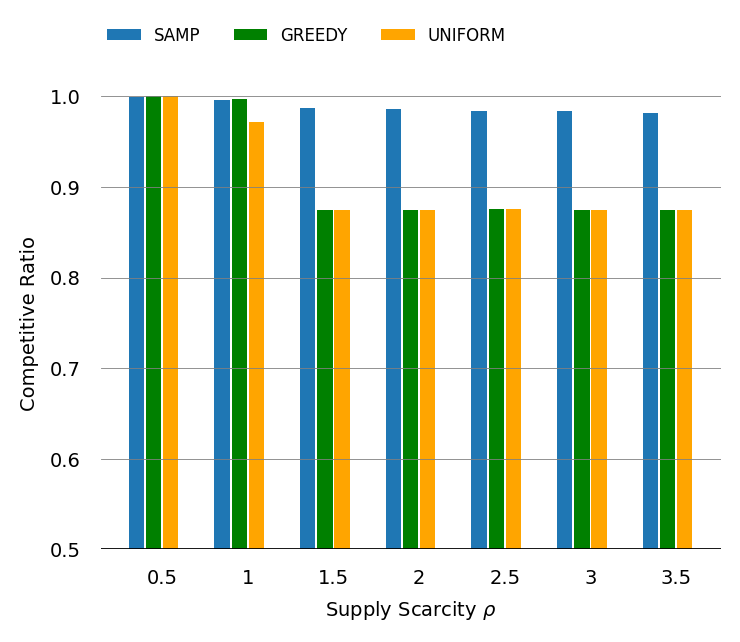

In [17]:
comp_ratio = pd.read_csv('Competitive_Ratio.csv')
supply_scar = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
figure(figsize = (4, 3), dpi = 200)
X_axis = np.arange(len(supply_scar))
plt.bar(X_axis - 0.2, comp_ratio.iloc[0], 0.18, label = 'SAMP')
plt.bar(X_axis, comp_ratio.iloc[1], 0.18, color = 'green', label = 'GREEDY')
plt.bar(X_axis + 0.2, comp_ratio.iloc[2], 0.18, color = 'orange', label = 'UNIFORM')
plt.xticks(X_axis + 0.2/2, supply_scar, fontsize = 7)
plt.yticks(fontsize = 7)
plt.axhline(y = 0.5, color = 'black', linewidth = 1)
plt.tick_params(
    axis = 'both',          # changes apply to the x-axis
    which = 'both',      # both major and minor ticks are affected
    left = False,
    bottom = False,      # ticks along the bottom edge are off
    top = False)         # ticks along the top edge are off
plt.xlabel(r'Supply Scarcity $\rho$', fontsize = 7)
plt.ylabel('Competitive Ratio', fontsize = 7)
plt.ylim(bottom = 0.5, top = 1)
plt.grid(color = 'gray', which = 'major', axis = 'y', linewidth = 0.3)
plt.legend(loc = (0, 1.1), fontsize = 6, ncol = len(supply_scar), frameon = False)
plt.box(False)
plt.savefig('Competitive_Ratio.pdf', bbox_inches = 'tight', format = 'pdf')
plt.show()